In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('sox_io')

import matplotlib.pyplot as plt
import requests
from utils import *
from wingbeat_datasets import *
from wingbeat_models import *


/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16


In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'conv1draw'
normalize = ''#"sample"

In [4]:
transforms_list = [FilterWingbeat(setting='bandpass')]#, TransformWingbeat(setting='psd')]

wbdset = WingbeatsDataset(dsname="twin_cages_experiment/sensorSD", clean=True, verbose=True, transform=FilterWingbeat(setting='bandpass'))
psdset = WingbeatsDataset(dsname="twin_cages_experiment/sensorSD", clean=True, verbose=True, transform=transforms.Compose([FilterWingbeat(setting='bandpass'), TransformWingbeat(setting='psdl2')]))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)

Found 59 in dataset: twin_cages_experiment/sensorSD, and 1 label(s): ['sensorSD']
No custom label applied.
Found 59 in dataset: twin_cages_experiment/sensorSD, and 1 label(s): ['sensorSD']
No custom label applied.


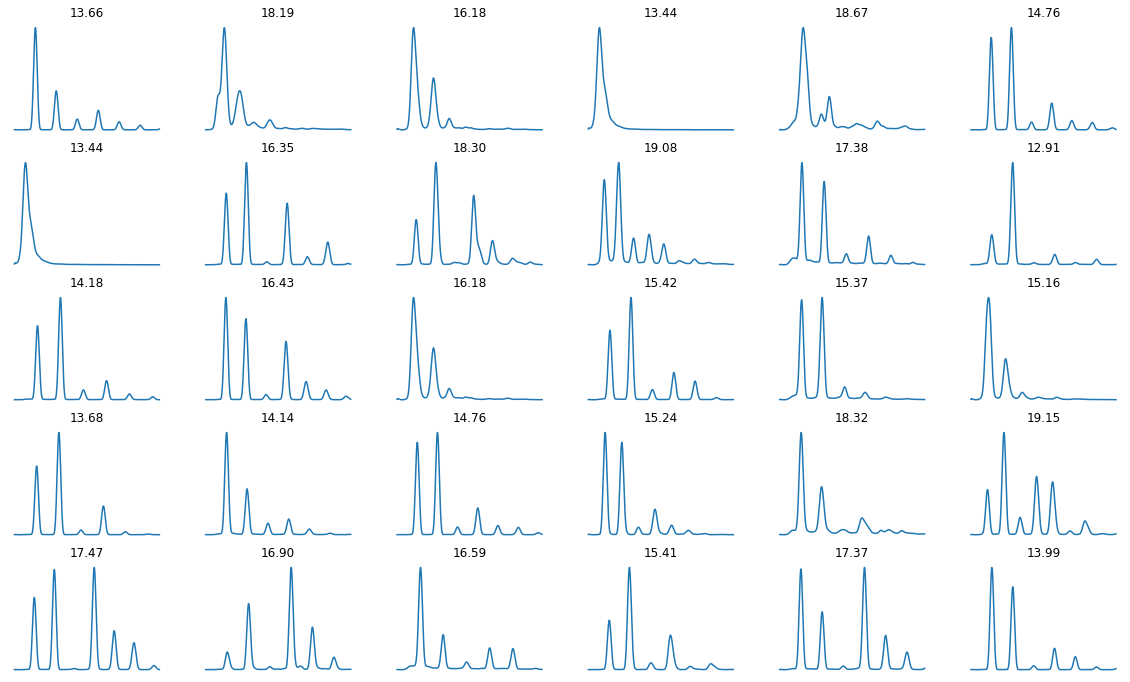

In [10]:
rands = np.random.randint(0,len(wbdset), len(wbdset))

plt.figure(figsize=(20,12))
for i in range(30):
    plt.subplot(5,6,i+1)
    
    sig = psdset[rands[i]][0][0,:1600]
    plt.plot(sig.T)
#     plt.title(f"{psdset.sums[i]:.1f}", y=.6)
    plt.title(f"{sig.sum():.2f}")
    plt.axis('off')

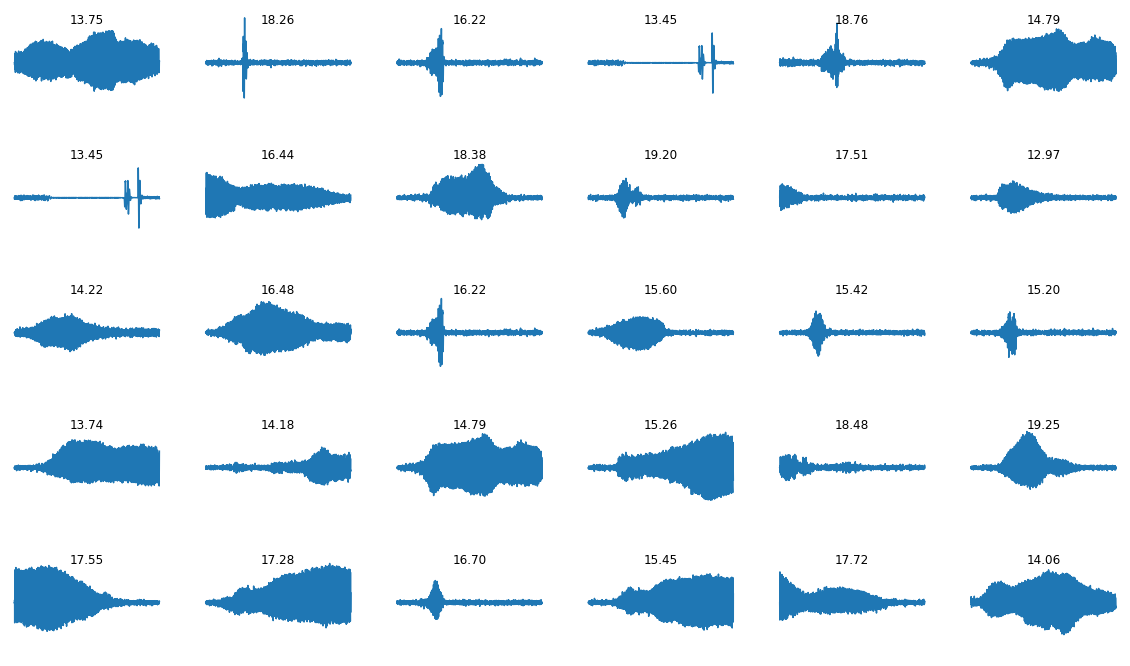

In [11]:
plt.figure(figsize=(20,12))
for i in range(30):
    plt.subplot(5,6,i+1)
    sig = wbdset[rands[i]][0]
    plt.plot(sig.T)
    plt.title(f"{wbdset.sums[rands[i]]:.2f}", y=.8)#, absum:{sig.abs().sum():.4f}")
    plt.axis('off')
    plt.ylim(-.065,.065)

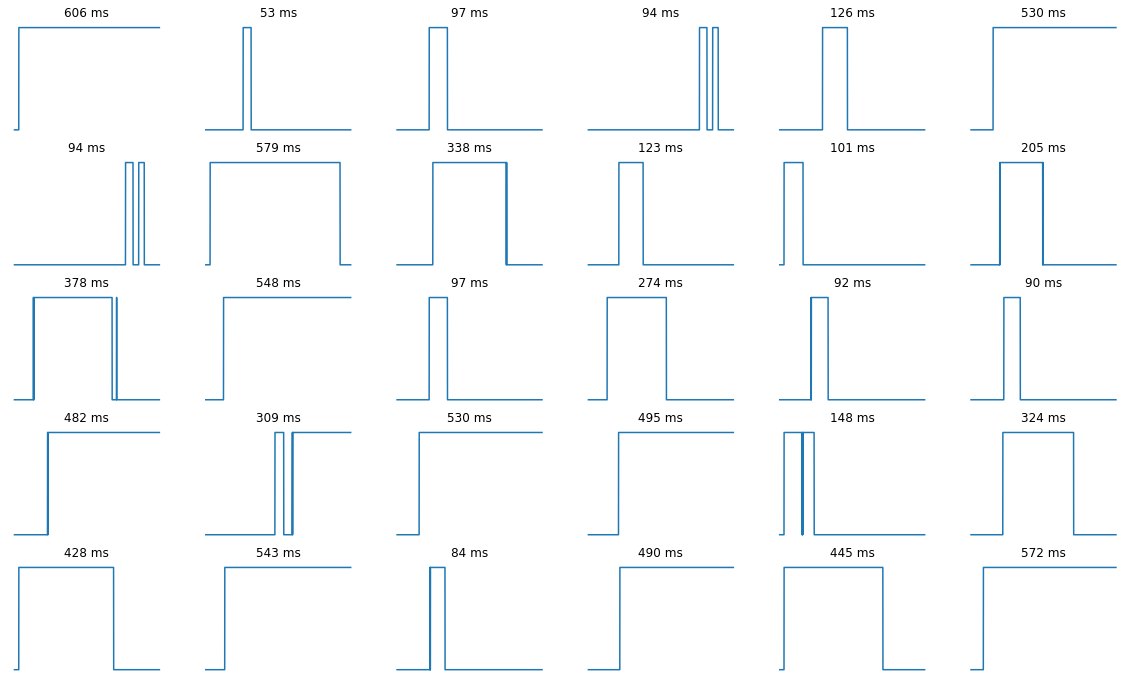

In [12]:
plt.figure(figsize=(20,12))
for i in range(30):
    plt.subplot(5,6,i+1)
    sig = wbdset[rands[i]][0]
    sig = pd.Series(sig.squeeze())
    sig = sig.abs().rolling(150).mean()
    sig = (sig>0.0025).astype(int)
    sig.plot()
    plt.title(f"{wingbeat_duration(sig):.0f} ms")
    plt.axis('off')

## Calculate mean flight duration for datasets

In [151]:
wbdset = WingbeatsDataset(dsname="twin_cages_experiment/sensorSD", clean=True, verbose=True, transform=FilterWingbeat(setting='bandpass'))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_WBduration_from_loader(dloader)[1:]

  0%|          | 0/2 [00:00<?, ?it/s]

Found 59 in dataset: twin_cages_experiment/sensorSD, and 1 label(s): ['sensorSD']
No custom label applied.


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


(307.864406779661, 303.875, 195.11594267208812)

In [152]:
wbdset = WingbeatsDataset(dsname="Suzukii_RL/Y", clean=True, verbose=True, transform=FilterWingbeat(setting='bandpass'))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_WBduration_from_loader(dloader)[1:]

  0%|          | 0/568 [00:00<?, ?it/s]

Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
No custom label applied.


100%|██████████| 568/568 [00:12<00:00, 43.80it/s]


(366.47160216888693, 353.4375, 159.9047685923064)

In [153]:
wbdset = WingbeatsDataset(dsname="Suzukii_RL/X", clean=True, verbose=True, transform=FilterWingbeat(setting='bandpass'))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_WBduration_from_loader(dloader)[1:]

  0%|          | 0/247 [00:00<?, ?it/s]

Found 7889 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
No custom label applied.


100%|██████████| 247/247 [00:05<00:00, 41.92it/s]


(383.1069368741285, 384.25, 158.96567412128442)

In [154]:
wbdset = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, verbose=True, transform=FilterWingbeat(setting='bandpass'))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_WBduration_from_loader(dloader)[1:]

  0%|          | 0/443 [00:00<?, ?it/s]

Found 14156 in dataset: Suzukii_RL/L, and 1 label(s): ['D. suzukii']
No custom label applied.


100%|██████████| 443/443 [00:10<00:00, 43.27it/s]


(362.4745514269568, 361.5, 161.32370543945484)

In [155]:
wbdset = WingbeatsDataset(dsname="Suzukii_RL/R", clean=True, verbose=True, transform=FilterWingbeat(setting='bandpass'))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_WBduration_from_loader(dloader)[1:]

  0%|          | 0/316 [00:00<?, ?it/s]

Found 10110 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
No custom label applied.


100%|██████████| 316/316 [00:07<00:00, 42.29it/s]


(384.96226508407517, 388.3125, 161.4340851419279)

## Power Spectral Density of datasets

  0%|          | 0/2 [00:00<?, ?it/s]

Found 59 in dataset: twin_cages_experiment/sensorSD, and 1 label(s): ['sensorSD']
No custom label applied.


  0%|          | 0/247 [00:00<?, ?it/s]

Found 7889 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
No custom label applied.


100%|██████████| 247/247 [00:25<00:00,  9.67it/s]


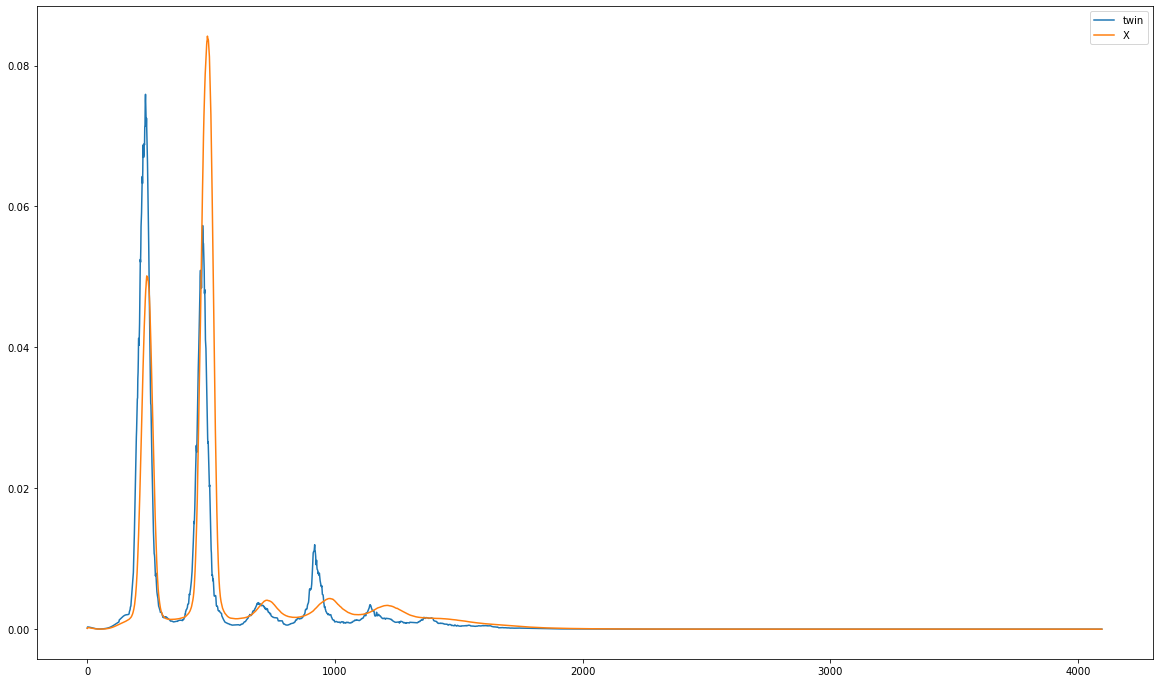

In [213]:
plt.figure(figsize=(20,12))
psdset = WingbeatsDataset(dsname="twin_cages_experiment/sensorSD", clean=True, verbose=True, transform=transforms.Compose([FilterWingbeat(setting='bandpass'), TransformWingbeat(setting='psdl2')]))
dloader = DataLoader(psdset, batch_size=32, num_workers=16)
get_medianWBDset_psd_from_loader(dloader).plot()

wbdset = WingbeatsDataset(dsname="Suzukii_RL/X", clean=True, verbose=True, transform=transforms.Compose([FilterWingbeat(setting='bandpass'), TransformWingbeat(setting='psdl2')]))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_medianWBDset_psd_from_loader(dloader).plot()

plt.legend(['twin','X'])

  0%|          | 0/247 [00:00<?, ?it/s]

Found 7889 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
No custom label applied.


  0%|          | 0/568 [00:00<?, ?it/s]

Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
No custom label applied.


  0%|          | 0/443 [00:00<?, ?it/s]

Found 14156 in dataset: Suzukii_RL/L, and 1 label(s): ['D. suzukii']
No custom label applied.


  0%|          | 0/316 [00:00<?, ?it/s]

Found 10110 in dataset: Suzukii_RL/R, and 1 label(s): ['D. suzukii']
No custom label applied.


100%|██████████| 316/316 [00:32<00:00,  9.68it/s]


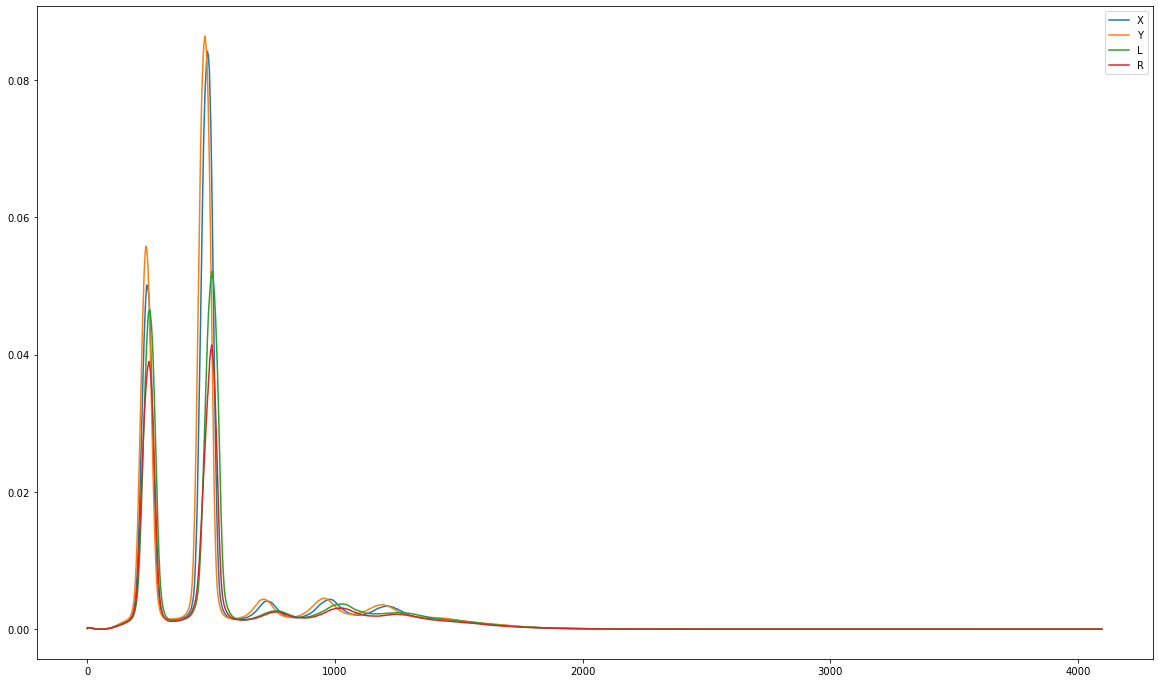

In [215]:
plt.figure(figsize=(20,12))

wbdset = WingbeatsDataset(dsname="Suzukii_RL/X", clean=True, verbose=True, transform=transforms.Compose([FilterWingbeat(setting='bandpass'), TransformWingbeat(setting='psdl2')]))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_medianWBDset_psd_from_loader(dloader).plot()

wbdset = WingbeatsDataset(dsname="Suzukii_RL/Y", clean=True, verbose=True, transform=transforms.Compose([FilterWingbeat(setting='bandpass'), TransformWingbeat(setting='psdl2')]))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_medianWBDset_psd_from_loader(dloader).plot()

wbdset = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, verbose=True, transform=transforms.Compose([FilterWingbeat(setting='bandpass'), TransformWingbeat(setting='psdl2')]))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_medianWBDset_psd_from_loader(dloader).plot()

wbdset = WingbeatsDataset(dsname="Suzukii_RL/R", clean=True, verbose=True, transform=transforms.Compose([FilterWingbeat(setting='bandpass'), TransformWingbeat(setting='psdl2')]))
dloader = DataLoader(wbdset, batch_size=32, num_workers=16)
get_medianWBDset_psd_from_loader(dloader).plot()

plt.legend(['X','Y','L','R'])